In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
import os

# Data Loading and Preprocessing
file_path = 'data/monatszahlen2405_verkehrsunfaelle_export_31_05_24_r.csv'  # Adjust the file path if needed
data = pd.read_csv(file_path, usecols=range(5))

23:01:51 - cmdstanpy - INFO - Chain [1] start processing
23:01:51 - cmdstanpy - INFO - Chain [1] done processing
23:01:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:01:51 - cmdstanpy - INFO - Chain [1] start processing
23:01:51 - cmdstanpy - INFO - Chain [1] done processing
23:01:51 - cmdstanpy - INFO - Chain [1] start processing
23:01:51 - cmdstanpy - INFO - Chain [1] done processing
23:01:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:01:51 - cmdstanpy - INFO - Chain [1] start processing
23:01:51 - cmdstanpy - INFO - Chain [1] done processing
23:01:51 - cmdstanpy - INFO - Chain [1] start processing
23:01:51 - cmdstanpy - INFO - Chain [1] done processing
23:01:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Best MAE: 7.50
Best Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
23:01:55 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
23:01:55 - cmdstanpy - INFO - Chain [1] start processing
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
23:01:55 - cmdstanpy - INFO - Chain [1] start processing
23:01:55 - cmdstanpy - INFO - Chain [1] start processing
23:01:55 - cmdstanpy - INFO - Chain [1] start processing
23:01:55 - cmdstanpy - INFO - Chain [1] start processing
23:01:55 - cmdstanpy

Cross-Validation Performance Metrics:
  horizon        mse      rmse       mae      mape    mdape     smape  \
0 37 days  67.154414  8.194780  6.488675  0.175031  0.15445  0.175543   
1 40 days  64.269674  8.016837  6.356978  0.184370  0.15445  0.179638   
2 41 days  63.103851  7.943793  6.318428  0.182544  0.14524  0.177839   
3 42 days  61.798407  7.861196  6.128945  0.179257  0.14524  0.174625   
4 45 days  62.015493  7.874992  6.178632  0.179282  0.14524  0.174528   

   coverage  
0  0.727273  
1  0.742424  
2  0.750000  
3  0.750000  
4  0.750000  

Evaluation on Test Set:
Mean Absolute Error (MAE): 7.50
Root Mean Squared Error (RMSE): 9.05
R^2 Score: 0.60


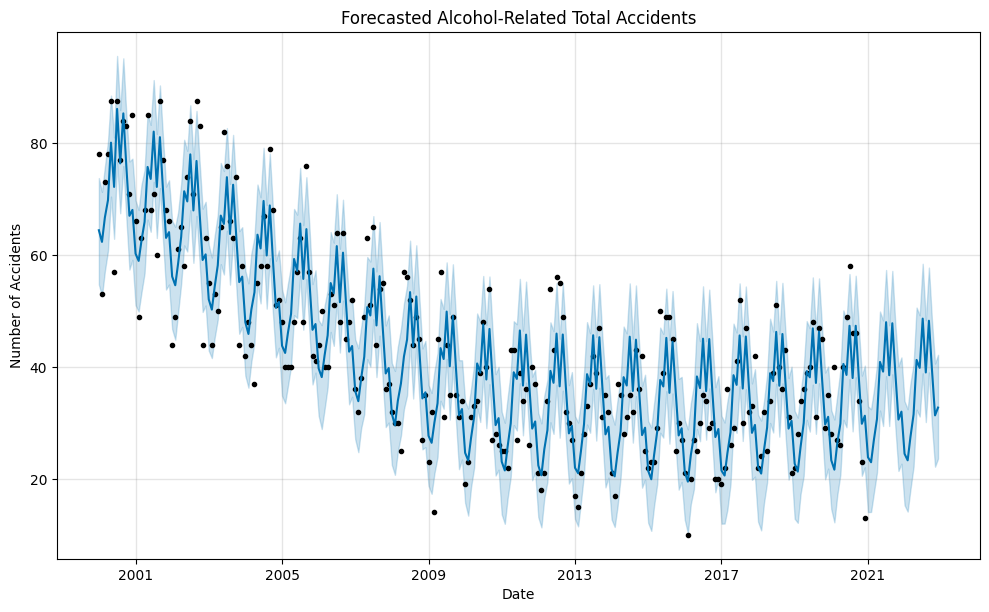

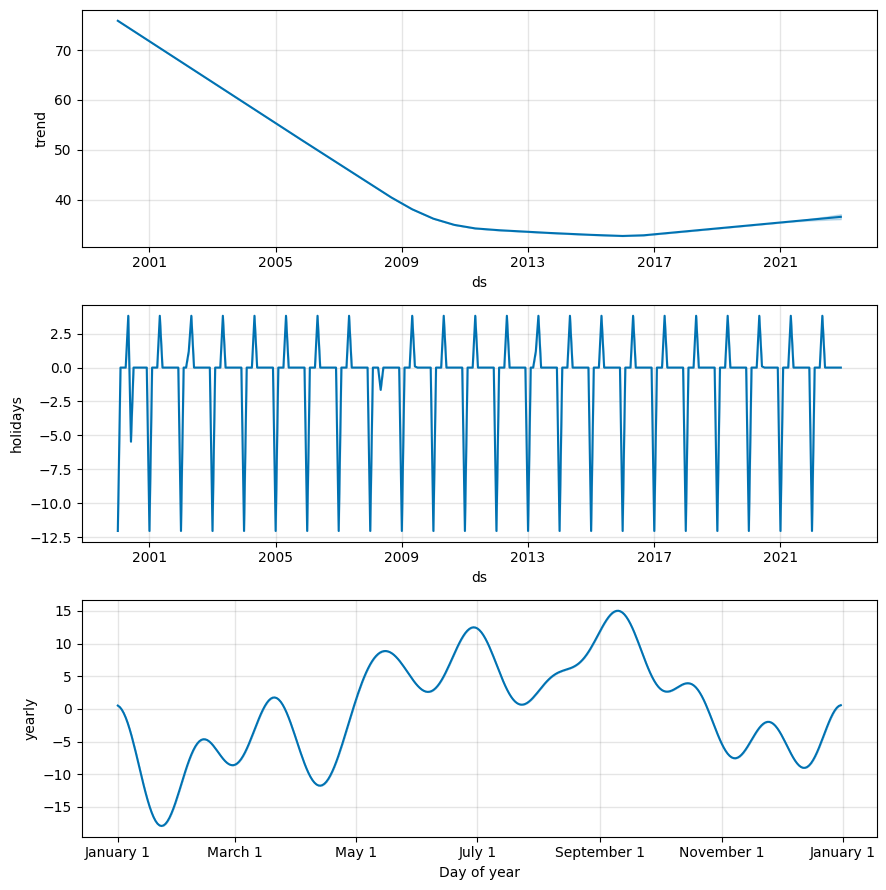

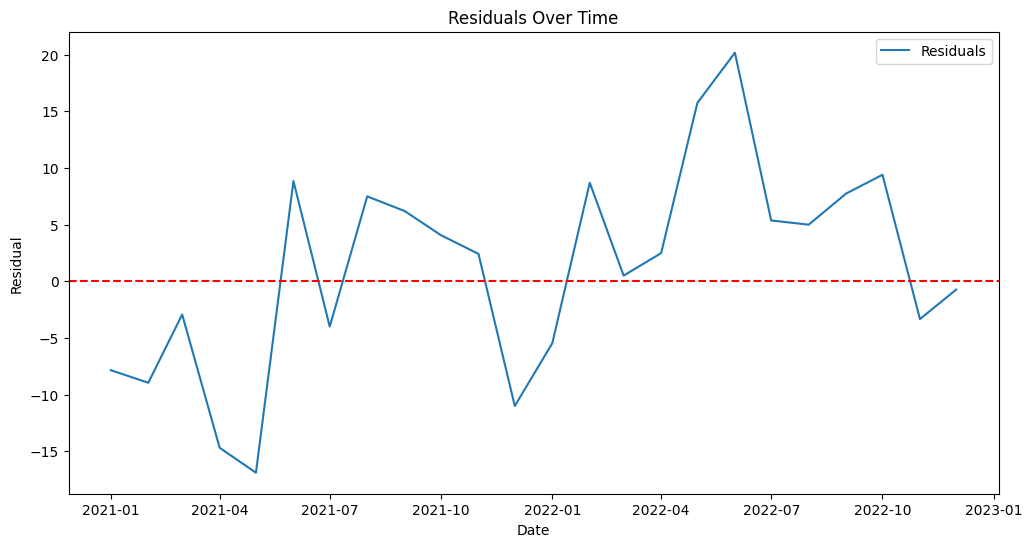

In [4]:
# Rename columns to English for easier interpretation
data.columns = ['category', 'type', 'year', 'month', 'value']

# Translate category values to English
category_map = {
    "Alkoholunfälle": "alcohol",
    "Fluchtunfälle": "escape",
    "Verkehrsunfälle": "traffic"
}
data['category'] = data['category'].map(category_map)

# Translate type values to English
type_map = {
    "insgesamt": "total",
    "Verletzte und Getötete": "injured_and_killed",
    "Verletzte": "injured",
    "Getötete": "killed",
    "mit Personenschäden": "with_injuries"
}
data['type'] = data['type'].map(type_map)

# Remove rows where 'month' contains 'Summe' or NaN values
data = data.dropna(subset=['month', 'year', 'value'])
data = data[data['month'] != 'Summe']

# Convert 'year' and 'month' to integers
data['year'] = data['year'].astype(int)
data['month'] = data['month'].astype(int)

# If 'month' values are greater than 12, adjust them
if data['month'].max() > 12:
    data['month'] = data['month'] % 100

# Remove rows with invalid 'year' and 'month' values
valid_years = range(2000, 2025)
data = data[data['year'].isin(valid_years)]
data = data[data['month'].between(1, 12)]

# Create 'date' column with error handling
data['date'] = pd.to_datetime(
    data[['year', 'month']].assign(day=1),
    errors='coerce'
)
# Drop rows where 'date' is NaT
data = data.dropna(subset=['date'])

# Filter data for 'alcohol' category and 'total' type
df_alcohol_total = data[(data['category'] == 'alcohol') & (data['type'] == 'total')]

# Sort data by date to ensure proper time series ordering
df_alcohol_total = df_alcohol_total.sort_values(by='date')

# Prepare data for Prophet
df_prophet = df_alcohol_total[['date', 'value']].rename(columns={'date': 'ds', 'value': 'y'})

# Handling Outliers
# Identify outliers using the 1.5*IQR rule
Q1 = df_prophet['y'].quantile(0.25)
Q3 = df_prophet['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with the upper bound
df_prophet['y'] = np.where(df_prophet['y'] > upper_bound, upper_bound, df_prophet['y'])
df_prophet['y'] = np.where(df_prophet['y'] < lower_bound, lower_bound, df_prophet['y'])

# Splitting Data into Training and Testing Sets
# We'll use data up to 2020-12-01 for training and after that for testing
train = df_prophet[df_prophet['ds'] <= '2020-12-01']
test = df_prophet[df_prophet['ds'] > '2020-12-01']

# Ensure that training and testing sets are not empty
if train.empty or test.empty:
    raise ValueError("Training or testing data is empty. Check the data splitting conditions.")

# Hyperparameter Tuning
# Define the parameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = list(ParameterGrid(param_grid))

# Store the results
best_mae = float('inf')
best_params = None
best_model = None

# Extract the actual values for evaluation
y_true = test['y'].values

for params in all_params:
    # Initialize the model with current parameters
    m = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        seasonality_mode=params['seasonality_mode'],
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    
    # Add German public holidays
    m.add_country_holidays(country_name='DE')
    
    # Fit the model
    m.fit(train)
    
    # Make future dataframe
    future = m.make_future_dataframe(periods=len(test), freq='MS')
    
    # Predict
    forecast = m.predict(future)
    
    # Extract the predictions for the test period
    forecast_test = forecast[forecast['ds'].isin(test['ds'])]
    y_pred = forecast_test['yhat'].values
    
    # Calculate MAE
    mae = mean_absolute_error(y_true, y_pred)
    
    # Update best params if current MAE is better
    if mae < best_mae:
        best_mae = mae
        best_params = params
        best_model = m
        best_forecast = forecast

print(f"Best MAE: {best_mae:.2f}")
print(f"Best Parameters: {best_params}")

# Use the best model for further analysis
model = best_model
forecast = best_forecast

# Cross-Validation
# Perform cross-validation
df_cv = cross_validation(
    model, 
    initial='730 days',  # Initial training period
    period='180 days',   # Period between cutoffs
    horizon='365 days',  # Forecast horizon
    parallel="processes"
)

# Compute performance metrics
df_p = performance_metrics(df_cv)
print("Cross-Validation Performance Metrics:")
print(df_p.head())

# Evaluating Model Performance
# Extract the predictions for the test period
forecast_test = forecast[forecast['ds'].isin(test['ds'])]
y_pred = forecast_test['yhat'].values

# Calculate evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"\nEvaluation on Test Set:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Plotting Results
# Plot the forecast
model.plot(forecast)
plt.title('Forecasted Alcohol-Related Total Accidents')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.show()

# Plot the forecast components
model.plot_components(forecast)
plt.show()

# Evaluating Residuals
# Calculate residuals
residuals = y_true - y_pred

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], residuals, label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.show()

In [5]:
# Saving the Model
# Ensure the 'models' directory exists
os.makedirs('models', exist_ok=True)

# Save the model to a pickle file
model_path = 'models/prophet_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)

print(f"Model saved to {model_path}")

Model saved to models/prophet_model.pkl


In [6]:
# Inference Code
# Load the model from the pickle file
with open(model_path, 'rb') as f:
    loaded_model = pickle.load(f)

# Specify the year and month for prediction
year = 2021  # Replace with the desired year
month = 1   # Replace with the desired month (1-12)

In [7]:
from datetime import datetime

# Create a datetime object for the specified date
input_date = datetime(year, month, 1)

# Create a DataFrame with the date for prediction
future_df = pd.DataFrame({'ds': [input_date]})

# Use the loaded model to make a prediction
forecast = loaded_model.predict(future_df)

# Extract the predicted value
prediction_value = forecast['yhat'].iloc[0]

# Display the prediction
print(f"\nPredicted number of alcohol-related total accidents in {year}-{month:02d}: {prediction_value:.2f}")

# Conclusion
print("\nModeling complete. The script has enhanced the Prophet model by incorporating hyperparameter tuning, holidays, outlier handling, and cross-validation.")
print(f"The final model has been saved to {model_path}.")



Predicted number of alcohol-related total accidents in 2021-01: 23.85

Modeling complete. The script has enhanced the Prophet model by incorporating hyperparameter tuning, holidays, outlier handling, and cross-validation.
The final model has been saved to models/prophet_model.pkl.
